<a href="https://colab.research.google.com/github/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/tf_agents_orso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Orso's live running on raw TF Agents

Make our bear Orso find all the honey in his home turf choosing the most convenient path.  

<img src='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/images/Orso.png?raw=1'>
<img src='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/images/turf.png?raw=1'>

https://opendatascience.com/bears-need-to-learn-as-well-practical-reinforcement-learning-with-tensorflow-2-0-tf-agents

https://github.com/tensorflow/agents

In [1]:
import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 9)
# mpl.rcParams['figure.figsize'] = (20, 12)
# mpl.rcParams["figure.dpi"] = 300

In [2]:
import sys
if 'google.colab' in sys.modules:
    !pip install -q easyagents 2>/dev/null
!pip install -q networkx==2.3.0 2>/dev/null

     |████████████████████████████████| 71kB 1.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 86.3MB 35kB/s 
     |████████████████████████████████| 22.2MB 1.5MB/s 
     |████████████████████████████████| 3.3MB 55.6MB/s 
     |████████████████████████████████| 13.1MB 240kB/s 
     |████████████████████████████████| 327kB 52.2MB/s 
     |████████████████████████████████| 839kB 55.7MB/s 
     |████████████████████████████████| 1.6MB 55.1MB/s 
     |████████████████████████████████| 2.5MB 45.2MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 450kB 51.6MB/s 
     |████████████████████████████████| 3.8MB 47.9MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 1.0MB 40.7MB/s 
     |████████████████████████████████| 1.8MB 2.9MB/s 


In [3]:
import sys
import warnings

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get update >/dev/null
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import matplotlib.pyplot as plt

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.agents.ppo import ppo_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.drivers.dynamic_episode_driver import DynamicEpisodeDriver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.networks import value_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [5]:
import tf_agents
tf_agents.__version__

'0.3.0'

In [6]:
import tensorflow as tf
tf.__version__

'2.0.1'

In [7]:
tf.random.set_seed(42)

In [8]:
!nvidia-smi

Sat Aug 29 09:28:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
import tensorflow_probability as tfp
tfp.__version__

'0.8.0'

### Orso's Environment (OpenAI Gym)

In [10]:
import gym
from gym import spaces
import matplotlib.image as mpi
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from IPython.display import display, clear_output
import networkx as nx
import numpy as np
import random

graph = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }

def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]

class OrsoEnv(gym.Env):
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self):
        self.map = graph
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0
        self._figure = None

        self.reset()
        self.optimum = self.calculate_customers_reward()

        base = "https://raw.githubusercontent.com/christianhidber/easyagents/master/jupyter_notebooks/images/"
        self.image_orso = mpi.imread(base + "Orso.png")
        self.image_cave = mpi.imread(base + "Cave.png")
        self.image_honey = mpi.imread(base + "Honey.png")
        self.image_empty_pot = mpi.imread(base + "EmptyPot.png")
        self.nx_graph, self.nx_pos = self._create_nx_graph()

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)

        self.cost = cost
        self.action = action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]
        self.reward = 0
        self.reward = (self.customerReward - self.cost) / self.optimum

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    def modulate_reward(self):
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / 2)
        self.customer_reward = {
            'S': 0
        }
        self._honeypot_places = []
        for customer_nr in range(1, number_of_customers + 1):
            self.customer_reward[int_to_state_name(customer_nr)] = 0

        # every consultant only visits a few random customers
        samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
        key_list = list(self.customer_reward.keys())
        for sample in samples:
            self.customer_reward[key_list[sample]] = 1000
            self._honeypot_places = self._honeypot_places + [key_list[sample]]

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = 'S'
        self.cost = 0
        self.action = 0
        self.lastStep_state = ''
        self.customerReward = None
        self._honeypot_places = None
        self.reward = 0
        self.envEpisodeCount += 1
        self.modulate_reward()
        self._figure = None
        return self.getObservation(state_name_to_int(self.state))

    def _create_nx_graph(self):
        """ generates the networkx graph representing orso's world with all its paths.

        :return: graph, positions
        """
        nx_graph = nx.Graph()
        for node_id in self.map.keys():
            zoom = 0.6
            image = self.image_empty_pot
            nx_graph.add_node(node_id, image=image, zoom=zoom)
        for source, connections in self.map.items():
            for target, cost in connections:
                if cost >= 300:
                    color = 'dodgerblue'
                elif cost >= 200:
                    color = 'darkgoldenrod'
                elif cost >= 100:
                    color = 'forestgreen'
                else:
                    color = 'greenyellow'
                nx_graph.add_edge(source, target, color=color, weight=6, image=self.image_cave)
        nx_pos = nx.kamada_kawai_layout(nx_graph)
        return nx_graph, nx_pos

    def _render_to_figure(self):
        """ Renders the current state as a graph with matplotlib
        """
        # draw graph using matplotlib
        if (self._figure is not None):
            plt.close(self._figure)
        self._figure = plt.figure("BeraterEnv", figsize=(12, 9))
        if len(self._figure.axes) == 0:
            self._figure.add_subplot(1, 1, 1)
        self._figure.axes[0].cla()
        ax = self._figure.axes[0]

        edges = self.nx_graph.edges()
        edge_colors = [self.nx_graph[u][v]['color'] for u, v in edges]
        edge_weights = [self.nx_graph[u][v]['weight'] for u, v in edges]
        nx.draw(self.nx_graph, pos=self.nx_pos, ax=ax, node_color='lightgrey',
                edges=edges, edge_color=edge_colors, width=edge_weights)

        # draw images on graph nodes
        # set image (according to the current state) and sizes (make orso's current position larger)
        for node_id in self.nx_graph.nodes():
            node = self.nx_graph.node[node_id]
            node['zoom'] = 0.4
            if node_id == self.state:
                node['zoom'] = 0.6
            if node_id in self._honeypot_places:
                node['image'] = self.image_empty_pot
                if self.customer_reward[node_id] > 0:
                    node['image'] = self.image_honey
            else:
                node['image'] = None
            if node_id == 'S':
                node['image'] = self.image_cave
            if self.state == node_id:
                node['image'] = self.image_orso

        # position images
        for n in self.nx_pos:
            node = self.nx_graph.node[n]
            image = node['image']
            if image is not None: 
                xp, yp = self.nx_pos[n]
                offset_image = OffsetImage(image, node['zoom'])
                offset_image.image.axes = ax
                ab = AnnotationBbox(offset_image, (xp, yp),
                                    xybox=(0, 0),
                                    xycoords='data',
                                    boxcoords="offset points",
                                    pad=0.0,
                                    frameon=False
                                    )
                ax.add_artist(ab)

        self._figure.canvas.draw()

    def _render_ansi(self):
        result = ("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
                  " Step: " + ("%4.0f  " % self.stepCount) +
                  self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
                  ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
                  ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                          "%4.0f" % self.optimum)
                  )
        return result

    def _render_rgb(self):
        self._render_to_figure()
        self._figure.canvas.draw()
        buf = self._figure.canvas.tostring_rgb()
        num_cols, num_rows = self._figure.canvas.get_width_height()
        plt.close(self._figure)
        self._figure = None
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        return result

    def render(self, mode='human'):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'human':
            clear_output(wait=True)
            self._render_to_figure()
            plt.pause(0.01)
            return
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
          

In [11]:
env = OrsoEnv()
env.reset()

array([    0.,  -300.,  -100.,   800., -1000.,     0.,     0.,     0.,
        1000.,     0.,     0.,     0.,     0.,  1000.,  1000.,  1000.,
        1000.,     0.,  1000.])

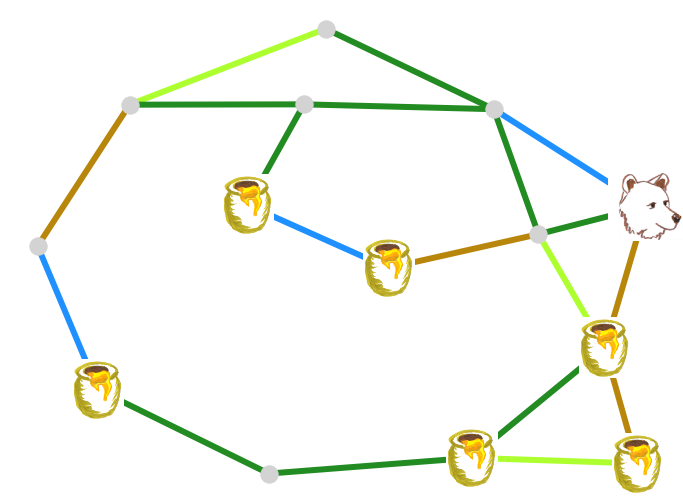

In [12]:
env.render() 

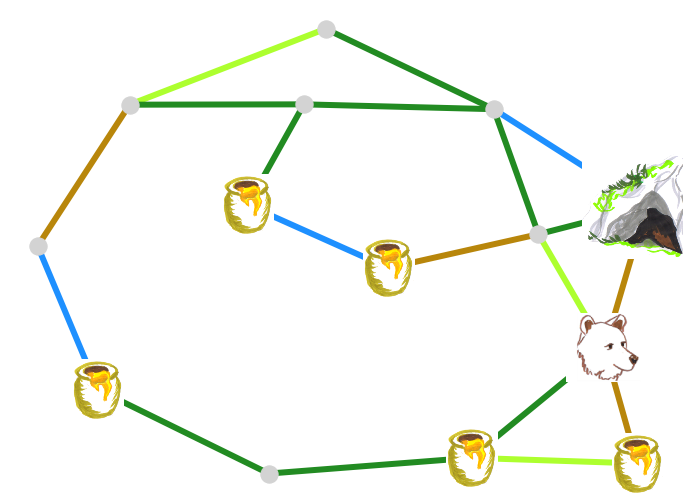

In [13]:
env.step(2)
env.render()

### Register with OpenAI Gym

In [14]:
env_name="Orso-v1"

env = gym.envs.registration.register(id=env_name,entry_point=OrsoEnv, max_episode_steps=25)

# two envs for train and eval
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

# converted to tf-agents tensorflow envs
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Start paying attention starting from here on

## PPO is the RL Algorithm of our choice
* a reinforcement learning strategy
* on-policy algorithm (data is generated with current policy and permanantly updated)
* evolution of policy gradient
* compatible with a default deep learning setup
* default when making an experiment is inexpensive

https://arxiv.org/abs/1707.06347
<br>
https://spinningup.openai.com/en/latest/user/algorithms.html
<br>
https://spinningup.openai.com/en/latest/algorithms/ppo.html

### PPO among all the other RL Algorihtms

<img src='https://spinningup.openai.com/en/latest/_images/rl_algorithms_9_15.svg'>

https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html

### PPO uses two networks
_given an observation_
* Value Network (Critic): what reward to expect?
* Actor Network (Policy): which action to take?

<!-- ![PPO Networks](https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/talk/ppo-xander.jpg?raw=1)

Xander Steenbrugge, Policy Gradient methods and Proximal Policy Optimization (PPO): diving into Deep RL!, https://youtu.be/5P7I-xPq8u8
 -->

### Value Network

Expected reward is a simple number

In [15]:
value_net = value_network.ValueNetwork(train_env.observation_spec(), 
                                       fc_layer_params=(500, 500, 500))

In [16]:
train_env.observation_spec()

BoundedTensorSpec(shape=(19,), dtype=tf.float32, name='observation', minimum=array([    0., -1000., -1000., -1000., -1000.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.], dtype=float32), maximum=array([  13., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000.], dtype=float32))

In [17]:
time_step = train_env.reset()
observation = time_step.observation
observation

<tf.Tensor: id=4, shape=(1, 19), dtype=float32, numpy=
array([[    0.,  -300.,   900.,  -200., -1000.,     0.,     0.,  1000.,
            0.,     0.,     0.,     0.,  1000.,     0.,  1000.,  1000.,
            0.,  1000.,  1000.]], dtype=float32)>

In [18]:
value_net(observation)[0].numpy()

array([-16.328474], dtype=float32)

### Actor Network

Spits out a probability distribution over the actions possible

In [19]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(500, 500, 500))

In [20]:
train_env.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(3))

In [21]:
# https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical
distribution, _ = actor_net(observation, time_step.step_type, None)
num_categories = len(distribution.logits.numpy()[0])
num_categories, distribution.logits.numpy()

(4, array([[  5.8726516, -25.996813 ,  17.613428 ,  29.887068 ]],
       dtype=float32))

In [22]:
# greedy, highest category
distribution.mode().numpy()

array([3])

### Custom Network (optional)

#### plain network using Keras layer API


In [23]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.4),
    
    tf.keras.layers.Dense(250, activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.4)
])    

#### just a bit of glue code

In [24]:
from tf_agents.utils import nest_utils

class CustomActorDistributionNetwork(actor_distribution_network.ActorDistributionNetwork):
    def __init__(self,
               input_tensor_spec,
               output_tensor_spec,
               custom_hidden_model):

        super(CustomActorDistributionNetwork, self).__init__(input_tensor_spec, output_tensor_spec)
        self._custom_hidden_model = custom_hidden_model

    def call(self, observations, step_type, network_state):
        state = self._custom_hidden_model(observations)
        outer_rank = nest_utils.get_outer_rank(observations, self.input_tensor_spec)
        output_actions = tf.nest.map_structure(
            lambda proj_net: proj_net(state, outer_rank), self._projection_networks)
        return output_actions, network_state


custom_actor_net = CustomActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    custom_hidden_model=model)

### What you need using tf-agents while training

![TF-Agents overview](https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/talk/tf-agents-overview.png?raw=1)

https://www.youtube.com/watch?v=tAOApRQAgpc
<br>
https://www.youtube.com/watch?v=-TTziY7EmUA

## <a href='https://github.com/christianhidber/easyagents/blob/master/jupyter_notebooks/talk/tf-agents-overview.png?raw=1' target='_blank'>Open in new window to view side by side with code</a>

### Agent

In [25]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

tf_ppo_agent = ppo_agent.PPOAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    # actor_net=actor_net,
    actor_net=custom_actor_net,
    value_net=value_net,
    optimizer=optimizer,
#     importance_ratio_clipping=.2,
#      initial_adaptive_kl_beta=0,
    entropy_regularization=0.01,
    value_pred_loss_coef=0.01,
#     value_pred_loss_coef=0,
    num_epochs=10)
tf_ppo_agent.initialize()

### Replay Buffer

In [26]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_ppo_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=10001)

avg_return = tf_metrics.AverageReturnMetric()
avg_length = tf_metrics.AverageEpisodeLengthMetric()

collect_driver = DynamicEpisodeDriver(train_env,
                                      tf_ppo_agent.collect_policy,
                                      observers=[replay_buffer.add_batch, avg_return, avg_length],
                                      num_episodes=10)

### Training Loop

1. collect data by playing
1. train with that data
1. erase all data 
1. repeat for a number of iterations

In [27]:
# just for optimized execution
tf_ppo_agent.train = common.function(tf_ppo_agent.train)
collect_driver.run = common.function(collect_driver.run)

collect_driver.run()
trajectories = replay_buffer.gather_all()

# train with a new set of trajectories
loss_info = tf_ppo_agent.train(trajectories)
loss_info

LossInfo(loss=<tf.Tensor: id=13601, shape=(), dtype=float32, numpy=5.100105>, extra=PPOLossInfo(policy_gradient_loss=<tf.Tensor: id=13602, shape=(), dtype=float32, numpy=-0.07245598>, value_estimation_loss=<tf.Tensor: id=13603, shape=(), dtype=float32, numpy=5.175468>, l2_regularization_loss=<tf.Tensor: id=13604, shape=(), dtype=float32, numpy=0.0>, entropy_regularization_loss=<tf.Tensor: id=13605, shape=(), dtype=float32, numpy=-0.013249623>, kl_penalty_loss=<tf.Tensor: id=13606, shape=(), dtype=float32, numpy=0.0103421435>))

In [28]:
num_iterations = 100  # @param {type:"integer"}
log_interval = 25 # @param {type:"integer"}

In [29]:
%%time

losses = []
policy_gradient_losses = []
value_estimation_losses = []
kl_losses = []
entropy_losses = []

returns = []
lengths = []

for iteration in range(num_iterations):
    
    # play to collect
    collect_driver.run()
    trajectories = replay_buffer.gather_all()
    
    # train with a new set of trajectories
    loss_info = tf_ppo_agent.train(trajectories)
    # and clear afterwards
    replay_buffer.clear()

    # just tracking of losses and other metrics
    total_loss = loss_info.loss.numpy()
    losses.append(total_loss)

    policy_gradient_loss = loss_info.extra.policy_gradient_loss.numpy()
    policy_gradient_losses.append(policy_gradient_loss)
    
    value_estimation_loss = loss_info.extra.value_estimation_loss.numpy()
    value_estimation_losses.append(value_estimation_loss)

    kl_loss = loss_info.extra.kl_penalty_loss.numpy()
    kl_losses.append(kl_loss)

    entropy_losses.append(loss_info.extra.entropy_regularization_loss.numpy())

    returns.append(avg_return.result().numpy())
    lengths.append(avg_length.result().numpy())    

    # logging
    step = tf_ppo_agent.train_step_counter.numpy()
    if step % log_interval == 0:
        print('step = {0}: loss = {1}, avg return = {2}, avg length = {3}'.format(
            step, total_loss, avg_return.result().numpy(), avg_length.result().numpy()))

step = 50: loss = 4.627758026123047, avg return = -1.0241667032241821, avg length = 25.0
step = 100: loss = 0.5185308456420898, avg return = -0.5366666913032532, avg length = 25.0
step = 150: loss = 0.41886383295059204, avg return = -0.40666669607162476, avg length = 25.0
step = 200: loss = 0.24311111867427826, avg return = -0.23416666686534882, avg length = 25.0
step = 250: loss = 0.8763465881347656, avg return = -0.23000001907348633, avg length = 25.0
step = 300: loss = 0.33763909339904785, avg return = 0.01666664145886898, avg length = 25.0
step = 350: loss = 0.2662532925605774, avg return = 0.16999998688697815, avg length = 25.0
step = 400: loss = 0.3753356635570526, avg return = 0.020833304151892662, avg length = 25.0
step = 450: loss = 0.4093244969844818, avg return = 0.14416660368442535, avg length = 24.799999237060547
step = 500: loss = 0.40450239181518555, avg return = 0.3891666829586029, avg length = 22.700000762939453
step = 550: loss = 0.27109551429748535, avg return = 0.41

### How did the training go?

We have defined a couple of surrogate losses which do not necessarily represent the performance of the policy.

* actor loss: as explained here https://youtu.be/U7g7-Jzj9qo?t=669 actor loss going up can indicate the network learning for better performance.
* critic loss: coming closest to actually telling about performance (but would not be sufficent to train on in isolation)
* KL loss: will spike to avoid too much of a change in the parameters by measing differences between output distributions, makes sure we are not going off too far in a possibly wrong direction
* entropy loss: goes up making training go slower and experiments les likely over time

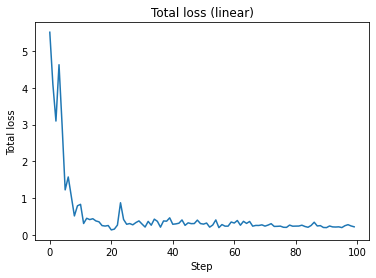

In [30]:
steps = range(0, num_iterations)

# plt.yscale('log')
plt.plot(steps, losses)
plt.title('Total loss (linear)')
plt.ylabel('Total loss')
plt.xlabel('Step');

In [31]:
import statistics

In [32]:
min(losses), max(losses), statistics.mean(losses)

(0.13823764, 5.5101843, 0.5273033)

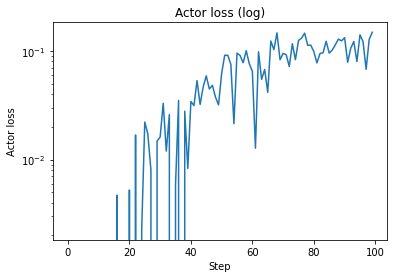

In [33]:
steps = range(0, num_iterations)

plt.yscale('log')

plt.plot(steps, policy_gradient_losses)
plt.title('Actor loss (log)')
plt.ylabel('Actor loss')
plt.xlabel('Step');
# plt.savefig('actor-loss-high-lr.png', transparent=True)

In [34]:
min(policy_gradient_losses), max(policy_gradient_losses), statistics.mean(policy_gradient_losses)

(-0.04365327, 0.14856878, 0.04957899)

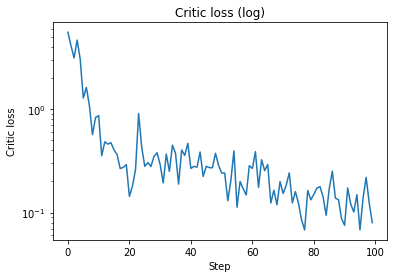

In [35]:
steps = range(0, num_iterations)

plt.yscale('log')
plt.plot(steps, value_estimation_losses)
plt.title('Critic loss (log)')
plt.ylabel('Critic loss')
plt.xlabel('Step');

In [36]:
min(value_estimation_losses), max(value_estimation_losses), statistics.mean(value_estimation_losses)

(0.0679469, 5.5642204, 0.48599586)

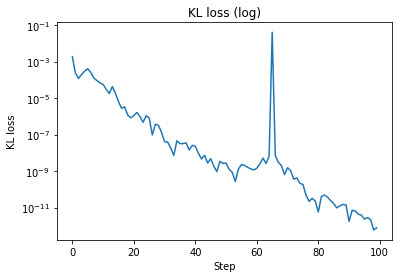

In [37]:
steps = range(0, num_iterations)

plt.yscale('log')
plt.plot(steps, kl_losses)
plt.title('KL loss (log)')
plt.ylabel('KL loss')
plt.xlabel('Step');
# plt.savefig('kl-loss-high-lr.png', transparent=True)

In [38]:
min(kl_losses), max(kl_losses), statistics.mean(kl_losses)

(5.935097e-13, 0.041030243, 0.00044905496)

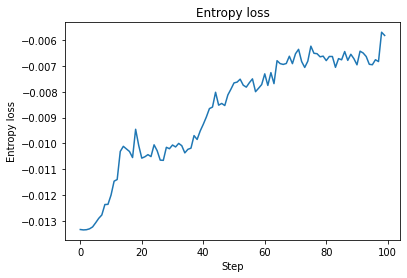

In [39]:
steps = range(0, num_iterations)

plt.plot(steps, entropy_losses)
plt.title('Entropy loss')
plt.ylabel('Entropy loss')
plt.xlabel('Step');

In [40]:
min(entropy_losses), max(entropy_losses), statistics.mean(entropy_losses)

(-0.013357862, -0.005690525, -0.008720651)

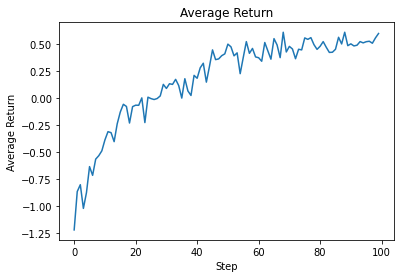

In [41]:
steps = range(0, num_iterations)
plt.plot(steps, returns)
plt.title('Average Return')
plt.ylabel('Average Return')
plt.xlabel('Step');

In [42]:
min(returns), max(returns)

(-1.2233331, 0.60583335)

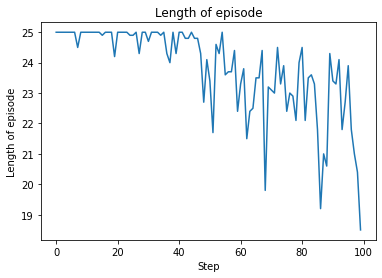

In [43]:
steps = range(0, num_iterations)

plt.plot(steps, lengths)
plt.title('Length of episode')
plt.ylabel('Length of episode')
plt.xlabel('Step');

In [44]:
min(lengths), max(lengths)

(18.5, 25.0)

### Trying out the policy network

In [45]:
time_step = eval_env.reset()
observation = time_step.observation

In [46]:
# TODO: how do we get the trained critic network?
# value_net(observation)[0].numpy()


_for play we just need the policy_

In [47]:
# not a collect policy, we are trying our best here
policy = tf_ppo_agent.policy
policy.name

'greedy_policy'

In [48]:
print(time_step.observation)
action_step = policy.action(time_step)
print(action_step.action.numpy()[0])  
time_step = eval_env.step(action_step.action)
print(time_step.observation)

tf.Tensor(
[[    0.   700.  -100.   800. -1000.     0.  1000.     0.  1000.     0.
      0.  1000.  1000.  1000.     0.     0.     0.  1000.     0.]], shape=(1, 19), dtype=float32)
2
tf.Tensor(
[[   3. -200.  -50. -100. -200.    0. 1000.    0.    0.    0.    0. 1000.
  1000. 1000.    0.    0.    0. 1000.    0.]], shape=(1, 19), dtype=float32)


In [49]:
while not time_step.is_last():
#   print(time_step.observation.numpy())
  action_step = policy.action(time_step)
  print(action_step.action.numpy()[0])  
  time_step = eval_env.step(action_step.action)

2
2
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


### Let's finally watch our bear (most likely) fail

In [50]:
num_episodes = 1

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=5) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_ppo_agent.policy.action(time_step)
#       print(action_step.action.numpy()[0])  
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (864, 648) to (864, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
